/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training model for dataset1...


Training Progress:  76%|███████▌  | 38/50 [00:58<00:18,  1.55s/epoch, loss=0.0259, val_acc=0.984, val_loss=0.0422]


Early stopping at epoch 39


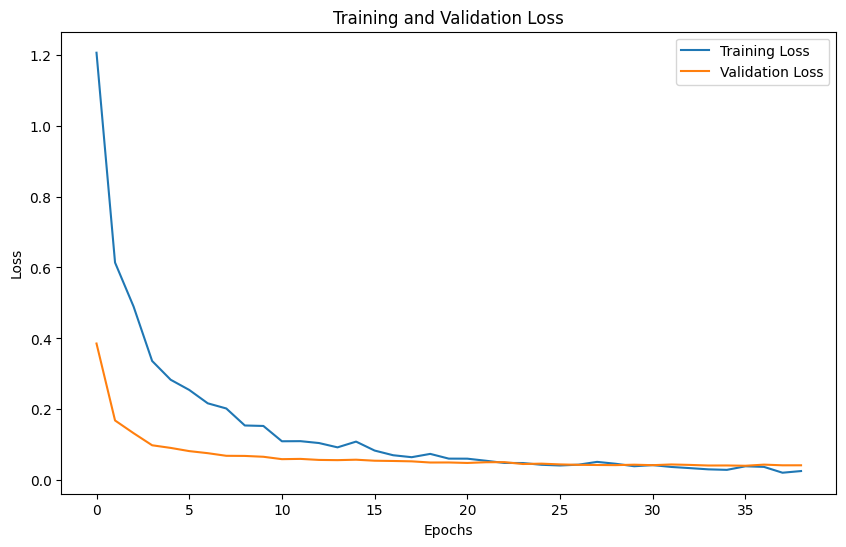

Training model for dataset2...


Training Progress:  98%|█████████▊| 49/50 [01:53<00:02,  2.31s/epoch, loss=0.218, val_acc=0.838, val_loss=0.406]


Early stopping at epoch 50


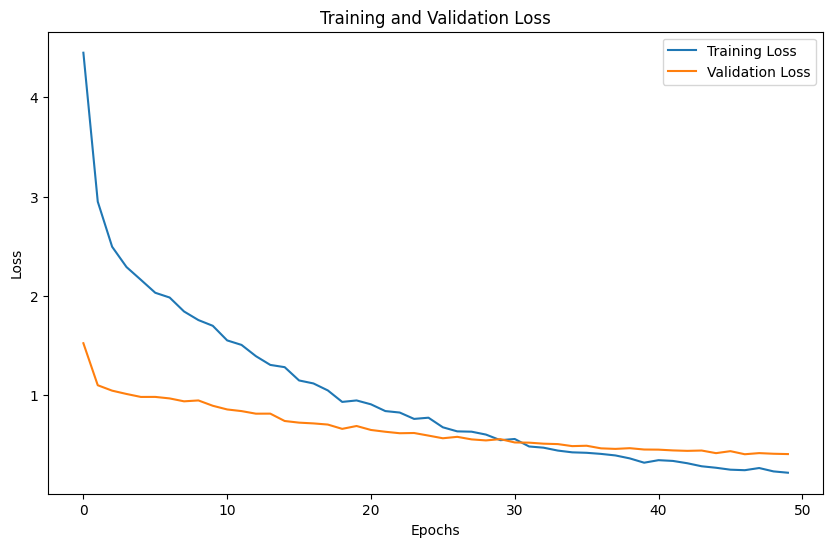

Training model for dataset3...


Training Progress:  58%|█████▊    | 29/50 [00:18<00:13,  1.60epoch/s, loss=0.665, val_acc=0.874, val_loss=0.337]


Early stopping at epoch 30


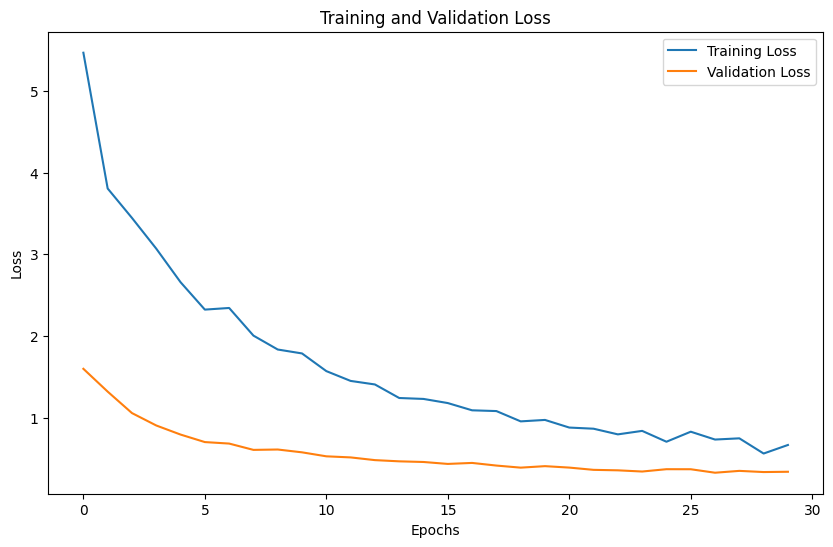

/tmp/ipykernel_30/3928218564.py:248: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Classification Report for dataset1:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       876
           1       0.98      0.96      0.97       270

    accuracy                           0.99      1146
   macro avg       0.98      0.98      0.98      1146
weighted avg       0.99      0.99      0.99      1146



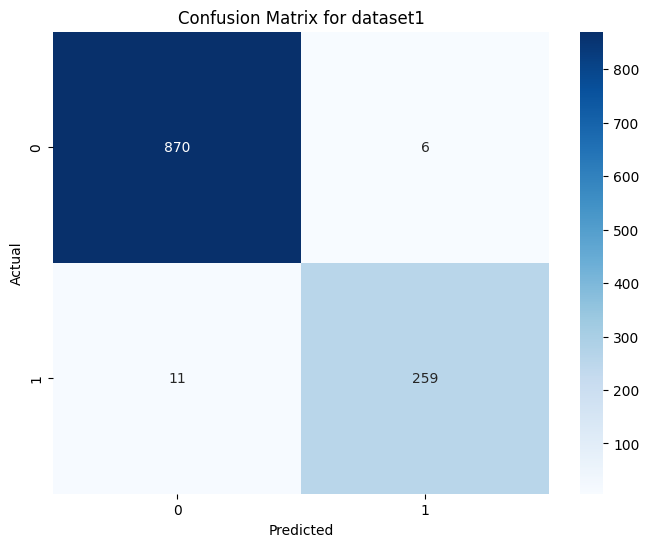

/tmp/ipykernel_30/3928218564.py:248: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Classification Report for dataset2:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       364
           1       0.83      0.85      0.84       410
           2       0.79      0.84      0.81       414

    accuracy                           0.84      1188
   macro avg       0.84      0.84      0.84      1188
weighted avg       0.84      0.84      0.84      1188



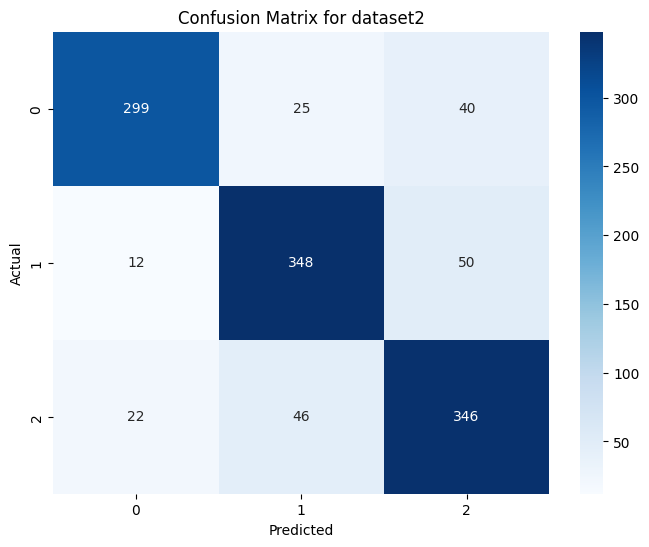

/tmp/ipykernel_30/3928218564.py:248: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Classification Report for dataset3:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81        76
           1       0.94      0.94      0.94       115
           2       0.90      0.84      0.87        85
           3       0.89      0.80      0.84        71
           4       0.81      0.91      0.86        98

    accuracy                           0.87       445
   macro avg       0.87      0.86      0.86       445
weighted avg       0.87      0.87      0.87       445



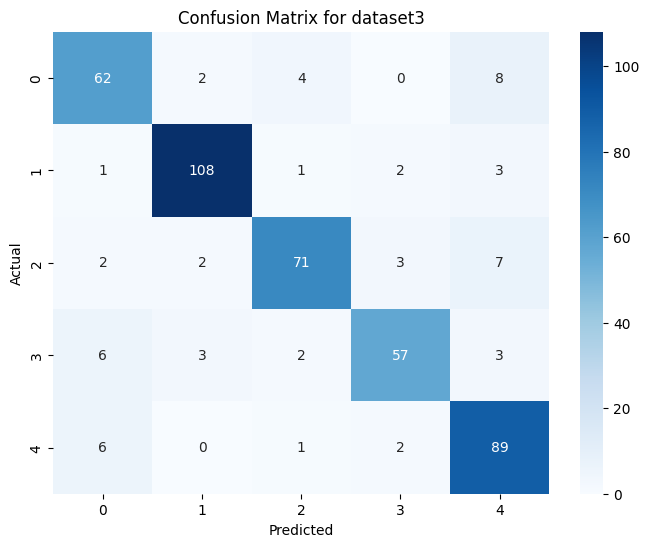

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load datasets from Kaggle input directories
data1 = pd.read_csv("/kaggle/input/dts305/dataset1.csv", encoding="iso-8859-1")
data2 = pd.read_csv("/kaggle/input/dts305/dataset2.csv", encoding="iso-8859-1")
data3 = pd.read_csv("/kaggle/input/dts305/dataset3.csv", encoding="iso-8859-1")

# Drop missing values
data1 = data1.dropna()
data2 = data2.dropna()
data3 = data3.dropna()

# Rename columns for consistency
data2 = data2.rename(columns={'Comment': 'text'})
data3 = data3.rename(columns={'Text': 'text'})

# Create label mappings
label_map1 = {0: 0, 1: 1}
label_map2 = {label: idx for idx, label in enumerate(data2['Emotion'].unique())}
label_map3 = {label: idx for idx, label in enumerate(data3['Label'].unique())}

# Map labels to numerical values
data1['spam'] = data1['spam'].map(label_map1)
data2['Emotion'] = data2['Emotion'].map(label_map2)
data3['Label'] = data3['Label'].map(label_map3)

# Load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenization function
def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            'input_ids': self.texts[idx]['input_ids'].squeeze(),
            'attention_mask': self.texts[idx]['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create dataset from tokenized texts and labels
def create_dataset(data, label_column):
    texts = data['text'].tolist()
    labels = data[label_column].tolist()
    tokenized_texts = [tokenize_function(text) for text in texts]
    return TextDataset(tokenized_texts, labels)

# Prepare datasets
datasets = {
    'dataset1': create_dataset(data1, 'spam'),
    'dataset2': create_dataset(data2, 'Emotion'),
    'dataset3': create_dataset(data3, 'Label')
}

# Split datasets into 80% train and 20% test
train_datasets = {}
test_datasets = {}
for name, dataset in datasets.items():
    train_size = int(0.8 * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
    train_datasets[name] = train_dataset
    test_datasets[name] = test_dataset

# CNN model with batch normalization and dropout
class CNN_Text(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(CNN_Text, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv2d(1, 100, (3, embed_dim))
        self.conv2 = nn.Conv2d(1, 100, (4, embed_dim))
        self.conv3 = nn.Conv2d(1, 100, (5, embed_dim))
        self.batch_norm1 = nn.BatchNorm2d(100)
        self.batch_norm2 = nn.BatchNorm2d(100)
        self.batch_norm3 = nn.BatchNorm2d(100)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(300, num_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x1 = torch.relu(self.batch_norm1(self.conv1(x))).squeeze(3)
        x2 = torch.relu(self.batch_norm2(self.conv2(x))).squeeze(3)
        x3 = torch.relu(self.batch_norm3(self.conv3(x))).squeeze(3)
        x1 = torch.max_pool1d(x1, x1.size(2)).squeeze(2)
        x2 = torch.max_pool1d(x2, x2.size(2)).squeeze(2)
        x3 = torch.max_pool1d(x3, x3.size(2)).squeeze(2)
        x = torch.cat((x1, x2, x3), 1)
        x = self.dropout(x)
        return self.fc(x)

# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Training function with early stopping, learning rate scheduler, and loss tracking
def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4, patience=3, model_save_path='best_model.pth'):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
    
    early_stopping_counter = 0
    best_val_loss = float('inf')
    progress_bar = tqdm(range(num_epochs), desc="Training Progress", unit="epoch")

    train_losses = []  # Store training losses
    val_losses = []    # Store validation losses

    for epoch in progress_bar:
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_acc = 0
        val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_acc += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_acc / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        progress_bar.set_postfix(loss=avg_loss, val_loss=avg_val_loss, val_acc=val_accuracy)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), model_save_path)
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        scheduler.step(avg_val_loss)

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Prepare DataLoader
def prepare_dataloader(dataset, batch_size=128):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

vocab_size = len(tokenizer)
embed_dim = 128

# Train the model for each dataset
for name, train_dataset in train_datasets.items():
    num_classes = len(set([sample['labels'].item() for sample in train_dataset]))
    model = CNN_Text(vocab_size, embed_dim, num_classes).to(device)
    
    model.apply(init_weights)
    
    train_loader = prepare_dataloader(train_dataset)
    val_loader = prepare_dataloader(test_datasets[name])

    print(f"Training model for {name}...")
    
    model_save_path = f"best_model_{name}.pth"
    train_model(model, train_loader, val_loader, model_save_path=model_save_path)

# Function to get predictions and true labels
def get_predictions_and_labels(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    return y_true, y_pred

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, dataset_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.show()

# Evaluate and visualize results for each dataset
for name, test_dataset in test_datasets.items():
    num_classes = len(set([sample['labels'].item() for sample in test_dataset]))
    model = CNN_Text(vocab_size, embed_dim, num_classes).to(device)
    
    model_save_path = f"best_model_{name}.pth"
    model.load_state_dict(torch.load(model_save_path))
    
    val_loader = prepare_dataloader(test_dataset)

    y_true, y_pred = get_predictions_and_labels(model, val_loader)

    print(f"Classification Report for {name}:")
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(num_classes)]))

    class_names = [str(i) for i in range(num_classes)]
    plot_confusion_matrix(y_true, y_pred, class_names, dataset_name=name)
